
Customer2Vec

We learn good semantic representations for customers (users) from transactional data using doc2vec. Each customer is a document, orders are sentences, and products are words. We also compare Customer2Vec with the baseline representations obtained using k-means on manually designed features.

Detailed Description
See D005 in descriptions

Data
We use external Instacart dataset (see datasets). Please download and unzip the dataset to 'data' folder before running this notebook.

Papers
Arora2016, Stiebellehner2017 (see papers)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 24



Data Exploration and Preparation

In [ ]:
os.getcwd()
os.listdir('./')
#os.listdir('/content/drive/MyDrive/Colab Notebooks/dataset/instacart-market-basket-analysis/')
#DATA_PATH = './content/drive/MyDrive/Colab Notebooks/dataset/instacart-market-basket-analysis/'
DATA_PATH = './data/instacart-market-basket-analysis'
files_list = glob.glob(f'{DATA_PATH}/*.csv')

files_list

'/home/whguswka/PycharmProjects/py38kb'

['silhouette_2.png',
 'customer2vec.200d.model',
 'scatterplot_3.png',
 'simple_train.ipynb',
 'data',
 '.ipynb_checkpoints',
 'test.csv',
 'scatterplot_2.png',
 'torchkge',
 'AmpliGraph',
 'cust2vec.py',
 'dgl-ke',
 'output',
 'main.py',
 'nohup.out',
 'c2v_kb.ipynb',
 'scatterplot_1.png',
 'simple_train.py',
 'cust2vec.ipynb',
 'c2v.py',
 'client2vec.py',
 'models',
 '.idea',
 'kge_wikimedia.ipynb',
 'silhouette_list.png']

['./data/instacart-market-basket-analysis/order_products__prior.csv',
 './data/instacart-market-basket-analysis/order_products__train.csv',
 './data/instacart-market-basket-analysis/departments.csv',
 './data/instacart-market-basket-analysis/aisles.csv',
 './data/instacart-market-basket-analysis/orders.csv',
 './data/instacart-market-basket-analysis/products.csv',
 './data/instacart-market-basket-analysis/sample_submission.csv']

In [ ]:
data_dict = {}

for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(show_counts=True))
    data_dict[file.split('.')[1].split('/')[-1]] = data

print(f'Loaded data sets: {data_dict.keys()}')



Reading: ./data/instacart-market-basket-analysis/order_products__prior.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int64
 1   product_id         32434489 non-null  int64
 2   add_to_cart_order  32434489 non-null  int64
 3   reordered          32434489 non-null  int64
dtypes: int64(4)
memory usage: 989.8 MB
None


Reading: ./data/instacart-market-basket-analysis/order_products__train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null 

Establishing the Baselines: Basic Segmentation in a Manually Designed Feature Space

We start with designing several basic features and segmenting customers using this basic representation. Note that the dataset is also very limited and does not allow for advanced ferature engineering (there is no demographic data, etc).

Feature Engineering

In [ ]:
train_orders = data_dict['order_products__train']
prior_orders = data_dict['order_products__prior']
products = data_dict['products'].set_index('product_id')

orders = data_dict['orders']
prior_orders = prior_orders.merge(right=orders[['user_id','order_id','order_number']],on='order_id',how='left')

prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


In [ ]:
# Sample users to keep the problem computationaly tractable
# number of sample user = 38,241
USER_SUBSET = 50000 # len(set(prior_orders.user_id))
user_ids_sample = prior_orders['user_id'].sample(n=USER_SUBSET, replace=False)

In [ ]:
data_usage = 0.5

prior_orders_details = prior_orders[prior_orders.user_id.isin(user_ids_sample)].copy()
prior_orders_details['product_id'] = prior_orders_details['product_id'].astype(int)
prior_orders_details = prior_orders_details.merge(data_dict['products'], on='product_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['aisles'], on='aisle_id', how='left')
prior_orders_details = prior_orders_details.merge(data_dict['departments'], on='department_id', how='left')
prior_orders_details = prior_orders_details[:round(len(prior_orders_details)*data_usage)]
prior_orders_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,product_name,aisle_id,department_id,aisle,department
0,4,46842,1,0,178520,36,Plain Pre-Sliced Bagels,93,3,breakfast bakery,bakery
1,4,26434,2,1,178520,36,Honey/Lemon Cough Drops,11,11,cold flu allergy,personal care
2,4,39758,3,1,178520,36,Chewy 25% Low Sugar Chocolate Chip Granola,3,19,energy granola bars,snacks
3,4,27761,4,1,178520,36,Oats & Chocolate Chewy Bars,48,14,breakfast bars pastries,breakfast
4,4,10054,5,1,178520,36,Kellogg's Nutri-Grain Apple Cinnamon Cereal,48,14,breakfast bars pastries,breakfast


In [ ]:
# Create basic user features: relative purchase frequences in each depertment/aisle

feature_department = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['department'], aggfunc='count', fill_value=0)
print('feature_department pivot table')
#feature_department.head()
feature_department = feature_department.div(feature_department.sum(axis=1), axis=0)
print('feature_department div')
#feature_department.head()
feature_department.columns = feature_department.columns.droplevel(0)
print('feature_department droplevel(0)')
#feature_department.head()
feature_department = feature_department.reset_index()
print('feature_department reset_index')
#feature_department.head()
feature_aisle = pd.pivot_table(prior_orders_details, index=['user_id'], values=['product_id'], columns=['aisle'], aggfunc='count', fill_value=0)
print('feature_aisle')
#feature_aisle.head()
feature_aisle = feature_aisle.div(feature_aisle.sum(axis=1), axis=0)
print('feature_aisle pivot table')
#feature_aisle.head()
feature_aisle.columns = feature_aisle.columns.droplevel(0)
print('feature_aisle columns droplevel(0)')
#feature_aisle.head()
feature_aisle = feature_aisle.reset_index()
print('feature_aisle reset_index')
#feature_aisle.head()
feature_df = feature_department.merge(feature_aisle, how='left', on='user_id').set_index('user_id')
feature_df.iloc[:5, :10] # show first 10 columns (departments) only

feature_department pivot table
feature_department div
feature_department droplevel(0)
feature_department reset_index
feature_aisle
feature_aisle pivot table
feature_aisle columns droplevel(0)
feature_aisle reset_index


,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta
user_id,,,,,,,,,,
11,0.000000,0.0,0.036364,0.200000,0.000000,0.0,0.072727,0.272727,0.036364,0.000000
14,0.066667,0.0,0.093333,0.013333,0.013333,0.0,0.066667,0.066667,0.000000,0.040000
17,0.114865,0.0,0.027027,0.175676,0.027027,0.0,0.020270,0.141892,0.033784,0.027027
19,0.000000,0.0,0.073684,0.105263,0.021053,0.0,0.063158,0.147368,0.021053,0.031579
26,0.050000,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.100000,0.050000,0.000000


In [ ]:
len(feature_df.columns)
feature_df.head()

155

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing_x,other_x,pantry,personal care,pets,produce,snacks,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing_y,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other_y,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,0.000000,0.0,0.036364,0.200000,0.000000,0.0,0.072727,0.272727,0.036364,0.000000,0.018182,0.090909,0.018182,0.000000,0.018182,0.018182,0.109091,0.000000,0.0,0.109091,0.000000,0.018182,0.018182,0.0,0.0,0.0,0.000000,0.036364,0.0,0.0,0.00,0.000000,0.000000,0.036364,0.000000,0.0,0.0,0.000000,0.018182,0.0,0.000000,0.072727,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.018182,0.0,0.000000,0.000000,0.018182,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.036364,0.018182,0.0,0.018182,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.018182,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.018182,0.0,0.018182,0.0,0.000000,0.000000,0.018182,0.0,0.018182,0.018182,0.036364,0.0,0.000000,0.0,0.0,0.036364,0.054545,0.000000,0.036364,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.018182,0.000000,0.000000,0.0,0.0,0.0,0.0,0.072727,0.000000,0.036364,0.018182,0.0,0.018182,0.000000,0.000000,0.00,0.036364,0.000000,0.0,0.0,0.000000,0.109091,0.000000,0.109091
14,0.066667,0.0,0.093333,0.013333,0.013333,0.0,0.066667,0.066667,0.000000,0.040000,0.120000,0.040000,0.013333,0.013333,0.000000,0.040000,0.226667,0.000000,0.0,0.160000,0.026667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.066667,0.000000,0.000000,0.0,0.0,0.013333,0.013333,0.0,0.000000,0.013333,0.013333,0.013333,0.0,0.000000,0.013333,0.0,


Visualize the Basic Space Using t-SNE

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Sample users to keep the problem computationaly tractable
mm_scale = MinMaxScaler()
feature_df_scale = pd.DataFrame(mm_scale.fit_transform(feature_df),
                                columns=feature_df.columns,
                                index=feature_df.index.values)

tsne_doc_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_features_doc = tsne_doc_features.fit_transform(feature_df_scale.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38010 samples in 0.002s...
[t-SNE] Computed neighbors for 38010 samples in 19.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38010
[t-SNE] Computed conditional probabilities for sample 2000 / 38010
[t-SNE] Computed conditional probabilities for sample 3000 / 38010
[t-SNE] Computed conditional probabilities for sample 4000 / 38010
[t-SNE] Computed conditional probabilities for sample 5000 / 38010
[t-SNE] Computed conditional probabilities for sample 6000 / 38010
[t-SNE] Computed conditional probabilities for sample 7000 / 38010
[t-SNE] Computed conditional probabilities for sample 8000 / 38010
[t-SNE] Computed conditional probabilities for sample 9000 / 38010
[t-SNE] Computed conditional probabilities for sample 10000 / 38010
[t-SNE] Computed conditional probabilities for sample 11000 / 38010
[t-SNE] Computed conditional probabilities for sample 12000 / 38010
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_doc_features = pd.DataFrame({'user_id':feature_df.index.values})
tsne_doc_features['tsne-2d-one'] = tsne_features_doc[:,0]
tsne_doc_features['tsne-2d-two'] = tsne_features_doc[:,1]
# tsne_doc_features['tsne-2d-three'] = tsne_features_doc[:,2]

<Figure size 1152x1152 with 0 Axes>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

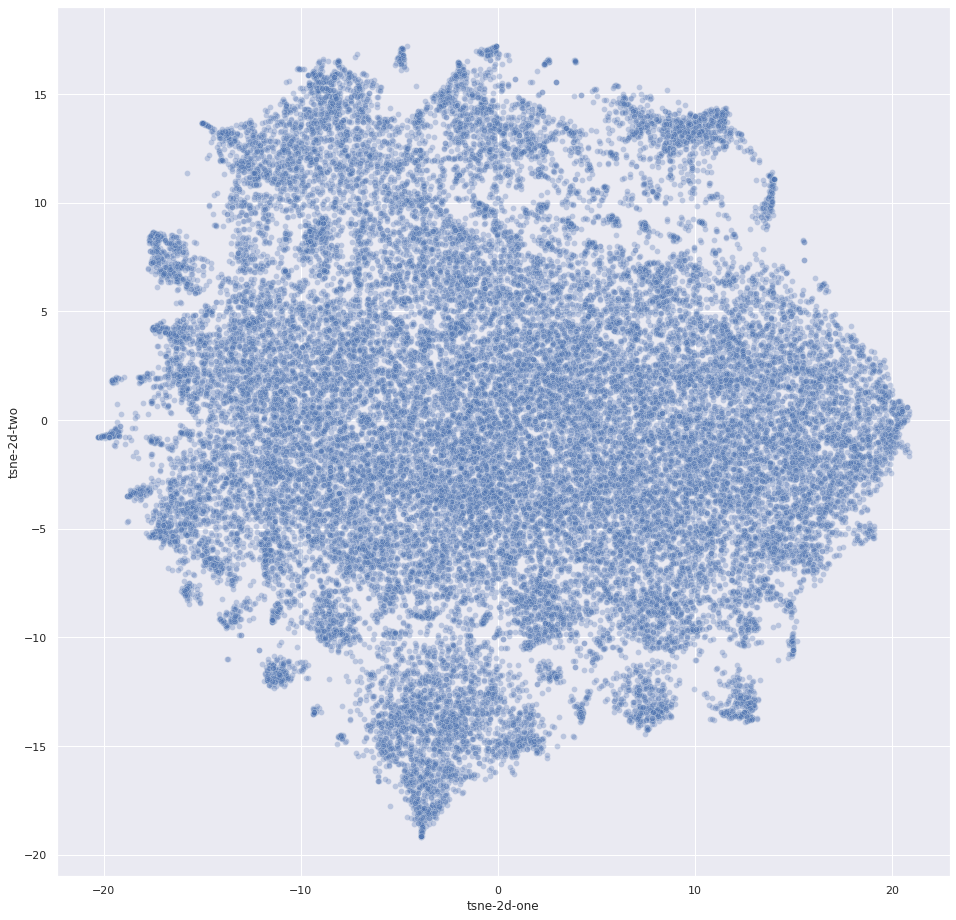

In [ ]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc_features,
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:
# Computing silhouette scores for different clustering option
silhouette_list = []
for k in tqdm(range(2, 20, 1)):
    clusters = KMeans(n_clusters=k).fit(feature_df_scale).labels_.astype(float)
    silhouette_avg = silhouette_score(feature_df_scale, clusters, metric="euclidean")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

<ipython-input-103-63243849ce49>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(2, 20, 1)):


  0%|          | 0/18 [00:00<?, ?it/s]

Silhouette score for 2 clusters is : 0.1206
Silhouette score for 3 clusters is : 0.06241
Silhouette score for 4 clusters is : 0.0537
Silhouette score for 5 clusters is : 0.04977
Silhouette score for 6 clusters is : 0.05289
Silhouette score for 7 clusters is : 0.02841
Silhouette score for 8 clusters is : 0.04698
Silhouette score for 9 clusters is : 0.04833
Silhouette score for 10 clusters is : 0.02816
Silhouette score for 11 clusters is : 0.02309
Silhouette score for 12 clusters is : 0.02203
Silhouette score for 13 clusters is : 0.02198
Silhouette score for 14 clusters is : 0.02314
Silhouette score for 15 clusters is : 0.02301
Silhouette score for 16 clusters is : 0.02125
Silhouette score for 17 clusters is : 0.02057
Silhouette score for 18 clusters is : 0.02267
Silhouette score for 19 clusters is : 0.02221


<Figure size 720x432 with 0 Axes>

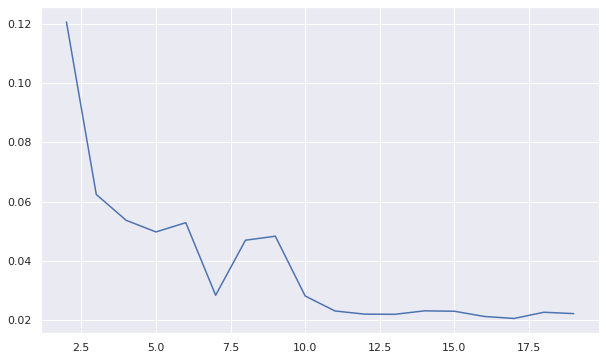

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20, 1), silhouette_list)


Conclusions: We can see from the t-SNE visualization it is possible to detect 2-3 clusters, but the silhouette score is close to zero and this feature space is not a good choice for customer segmentation. We should develop more advanced features and incorporate more domain knowledge to obtain better feature space for segmentation.

Customer2Vec, Step 1: Data Preparation


In this and next section, we are learning and exploring the customer semantic space using Doc2Vec.

In [ ]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders_details["product_id"] = prior_orders_details["product_id"].astype(str)

# It is important to sort order and products chronologically
prior_orders_details.sort_values(by=['user_id','order_number','add_to_cart_order'], inplace=True)

In [ ]:
combined_orders_by_user_id = prior_orders_details.groupby("user_id").apply(lambda order: ' '.join(order['product_id'].tolist()))

combined_orders_by_user_id = pd.DataFrame(combined_orders_by_user_id,columns=['all_orders'])
print(f'Number of orders: {combined_orders_by_user_id.shape[0]}')
combined_orders_by_user_id.reset_index(inplace=True)
combined_orders_by_user_id.user_id = combined_orders_by_user_id.user_id.astype(str)

combined_orders_by_user_id.head()

Number of orders: 38010


,user_id,all_orders
0,11,47601 18465 35640 35948 8670 14947 42585 41290 34658 33731 27959 36070 23400 35948 8309 8670 5605 95 19769 14947 12384 28465 26209 8230 30480 22950 34551 44632 15261 33037 20383 35321 27959 40738 41319 28465 8309 14947 34658 40055 24799 17706 33572 27959 48697 49374 8309 30563 5989 41909 17794 13176 4799 33021 21040
1,14,29509 23360 23803 23803 44212 29509 23819 34234 17923 33086 239 30295 4893 49481 46454 16776 9239 12232 21689 45066 27135 32115 33041 27012 15078 48190 34827 11703 46547 5818 11131 40348 39545 23803 29509 17556 44212 22849 29382 2927 14875 32428 35264 40286 1958 32115 48572 12358 8744 40478 9774 12448 5782 32428 45519 29509 22179 18439 18069 23803 8512 49010 40836 8744 23803 46979 13966 12429 33360 15134 3808 29509 37266 32211 15869
2,17,7350 18534 17762 42356 16797 6334 6212 30992 8730 10300 15925 21187 25307 20215 15125 7350 27629 48544 12855 32498 9641 19766 48682 15844 17762 7350 47141 18534 43986 36130 35419 16797 9387 21187 15125 6212 10921 7350 47141 17762 38760 21553 7026 7350 17762 31268 47577 7350 18534 36552 47031 17762 38444 14146 812 47940 7350 18534 17762 33560 29791 7350 47141 18534 17762 5077 42356 47141 18534 21553 17762 16797 19468 40592 18855 7350 18534 17762 16797 38618 7350 18534 17762 48544 4591 36463 4...
3,19,36227 18174 22520 11613 18799 26525 5209 1832 39987 31591 12318 39978 3364 22633 17008 14252 33756 24629 34887 43867 35123 2192 13822 11749 45037 15599 31707 30123 47193 5315 23483 41302 196 18102 44234 33122 44187 31487 43772 39993 3747 25367 43409 9901 37066 20156 22782 46023 31725 2848 3996 12108 35887 29255 35123 40348 21011 21001 11229 40674 44870 18987 15482 3334 2192 29284 22788 28221 21333 39107 23734 17008 15131 34724 42913 34690 25170 47805 41483 40974 28805 48437 4817 17008 14905 ...
4,26,32607 13219 45650 30592 44632 30592 10339 14947 31615 23377 19894 18531 17859 31130 9422 22849 46559 41596 25535 4091



Customer2Vec, Step 2: Train Doc2Vec model

We use implementation from Gensim adjusting the following parameters:

documents = users (each user is represented by a chronologically sorted list of products)

window = Maximum distance between the current and predicted word within a sentence.

vector_size = Dimensionality of the word vectors.

min_count = Ignores all words with total frequency lower than this.

Note that model training can take a long time (10+ hours).

In [ ]:
TRAIN_USER_MODEL = True    # True - create a new model, False - load a previosuly created model
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
from gensim.models.doc2vec import LabeledSentence, TaggedDocument, Doc2Vec
from gensim.models.word2vec import Word2Vec
import timeit
import gensim
import os

embeddings_dim = 200

os.getcwd()
filename = f'./models/customer2vec.{embeddings_dim}d_{str(data_usage)}.model'
if TRAIN_USER_MODEL:

    class TaggedDocumentIterator(object):
        def __init__(self, df):
           self.df = df
        def __iter__(self):
            for row in self.df.itertuples():
                yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['user_id']])

    it = TaggedDocumentIterator(combined_orders_by_user_id)

    doc_model = gensim.models.Doc2Vec(vector_size=embeddings_dim,
                                      window=5,
                                      min_count=10,
                                      workers=24,
                                      alpha=0.055,
                                      min_alpha=0.055,
                                      epochs=120)   # use fixed learning rate

    train_corpus = list(it)

    doc_model.build_vocab(train_corpus)

    for epoch in tqdm(range(10)):
        doc_model.alpha -= 0.005                    # decrease the learning rate
        doc_model.min_alpha = doc_model.alpha       # fix the learning rate, no decay
        doc_model.train(train_corpus, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)
        print('Iteration:', epoch)

    doc_model.save(filename)
    print(f'Model saved to [{filename}]')

else:
    filename
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

'/home/whguswka/PycharmProjects/py38kb'

<ipython-input-108-af9bb59a2309>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Model saved to [./models/customer2vec.200d_0.5.model]


In [ ]:
# doc_model.wv.index_to_key
# doc_model.wv.key_to_index
# doc_model.dv
# list(prior_orders["user_id"])
# list(set(prior_orders["user_id"]))[-10:]
# doc_model.dv.index_to_key

In [ ]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
# vocab_doc = list(doc_model.dv.index_to_key) # list(set(prior_orders["user_id"]))
# doc_vector_dict = {arg:doc_model.dv[arg] for arg in vocab_doc}
doc_vector_dict = {arg:doc_model.docvecs[arg] for arg in vocab_doc}
X_doc = pd.DataFrame(doc_vector_dict).T.values


X_doc.shape, len(vocab_doc), prior_orders["user_id"].nunique()

pd.DataFrame(X_doc).to_csv('./output/X_doc_{0}p_{1}d.csv'.format(data_usage*100, len(tsne_doc_features.columns)-1))

((38010, 200), 38010, 206209)


Customer2Vec, Step 3: Visualize the Customer Semantic Space Using t-SNE

In [ ]:
user_ids_sample_str = set([str(id) for id in user_ids_sample])
idx = []
for i, user_id in enumerate(doc_vector_dict):
    if user_id in user_ids_sample_str:
        idx.append(i)
X_doc_subset = X_doc[idx] # only sampled user IDs
X_doc_subset.shape

(38010, 200)

In [ ]:
doc_vec_subset = pd.DataFrame(doc_vector_dict).T.iloc[idx]
doc_vec_subset.shape

(38010, 200)

In [ ]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc_subset, X_doc_subset, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

/home/whguswka/anaconda3/envs/py38kb/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38010 samples in 1.748s...
[t-SNE] Computed neighbors for 38010 samples in 16.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38010
[t-SNE] Computed conditional probabilities for sample 2000 / 38010
[t-SNE] Computed conditional probabilities for sample 3000 / 38010
[t-SNE] Computed conditional probabilities for sample 4000 / 38010
[t-SNE] Computed conditional probabilities for sample 5000 / 38010
[t-SNE] Computed conditional probabilities for sample 6000 / 38010
[t-SNE] Computed conditional probabilities for sample 7000 / 38010
[t-SNE] Computed conditional probabilities for sample 8000 / 38010
[t-SNE] Computed conditional probabilities for sample 9000 / 38010
[t-SNE] Computed conditional probabilities for sample 10000 / 38010
[t-SNE] Computed conditional probabilities for sample 11000 / 38010
[t-SNE] Computed conditional probabilities for sample 12000 / 38010
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_doc = pd.DataFrame()

tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]
'''
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]
tsne_doc['tsne-2d-three'] = tsne_results_doc[:,2]
'''

"\ntsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]\ntsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]\ntsne_doc['tsne-2d-three'] = tsne_results_doc[:,2]\n"

<Figure size 1152x1152 with 0 Axes>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

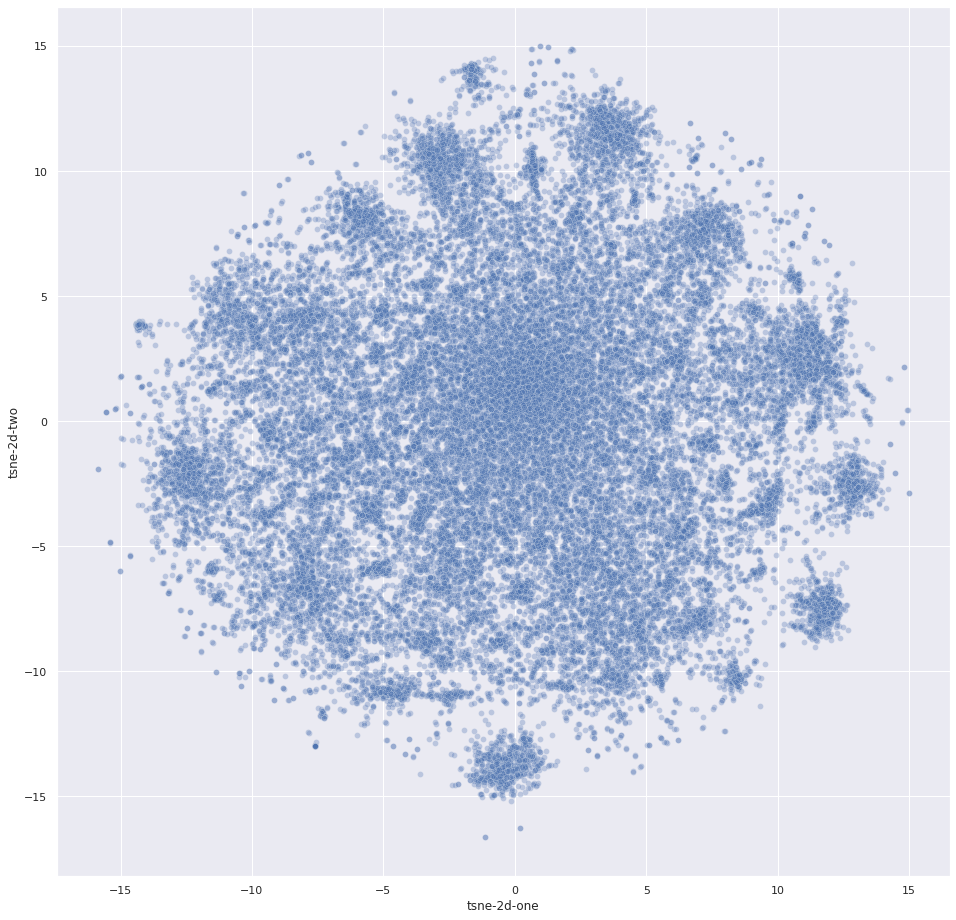

In [ ]:
plt.figure(figsize=(16,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

Customer2Vec, Step 4: Segmentation in the Customer Semantic Space Using t-SNE

In [ ]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc_subset)).labels_.astype(float)

silhouette_list = []
for k in tqdm(range(2, 22, 1)):
    latent_clusters = cluster_cosine(X_doc_subset, k)
    silhouette_avg = silhouette_score(X_doc_subset, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

<ipython-input-116-20ca84627f4f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(2, 22, 1)):


  0%|          | 0/20 [00:00<?, ?it/s]

Silhouette score for 2 clusters is : -0.0155
Silhouette score for 3 clusters is : -0.02121
Silhouette score for 4 clusters is : -0.02385
Silhouette score for 5 clusters is : -0.03383
Silhouette score for 6 clusters is : -0.03197
Silhouette score for 7 clusters is : -0.02945
Silhouette score for 8 clusters is : -0.02808
Silhouette score for 9 clusters is : -0.02646
Silhouette score for 10 clusters is : -0.0227
Silhouette score for 11 clusters is : -0.02214
Silhouette score for 12 clusters is : -0.02029
Silhouette score for 13 clusters is : -0.01841
Silhouette score for 14 clusters is : -0.01963
Silhouette score for 15 clusters is : -0.01714
Silhouette score for 16 clusters is : -0.02148
Silhouette score for 17 clusters is : -0.02163
Silhouette score for 18 clusters is : -0.01951
Silhouette score for 19 clusters is : -0.01957
Silhouette score for 20 clusters is : -0.01482
Silhouette score for 21 clusters is : -0.01602


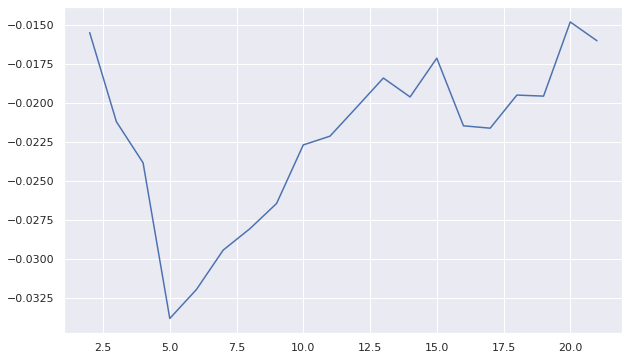

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(2,22,1), silhouette_list);

In [ ]:
N_CLUSTER = 17

latent_clusters = cluster_cosine(X_doc_subset, N_CLUSTER)
doc_vec_end = doc_vec_subset.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

pd.DataFrame(tsne_doc).to_csv('./output/tsne_doc_{0}p_{1}d.csv'.format(data_usage*100, len(tsne_doc_features.columns)-1))

doc_vec_end['label'].value_counts()

5.0     4772
16.0    4336
6.0     4147
8.0     3073
14.0    2984
7.0     2521
2.0     2390
4.0     1852
11.0    1837
3.0     1705
1.0     1495
15.0    1352
12.0    1296
10.0    1265
9.0     1189
13.0     997
0.0      799
Name: label, dtype: int64

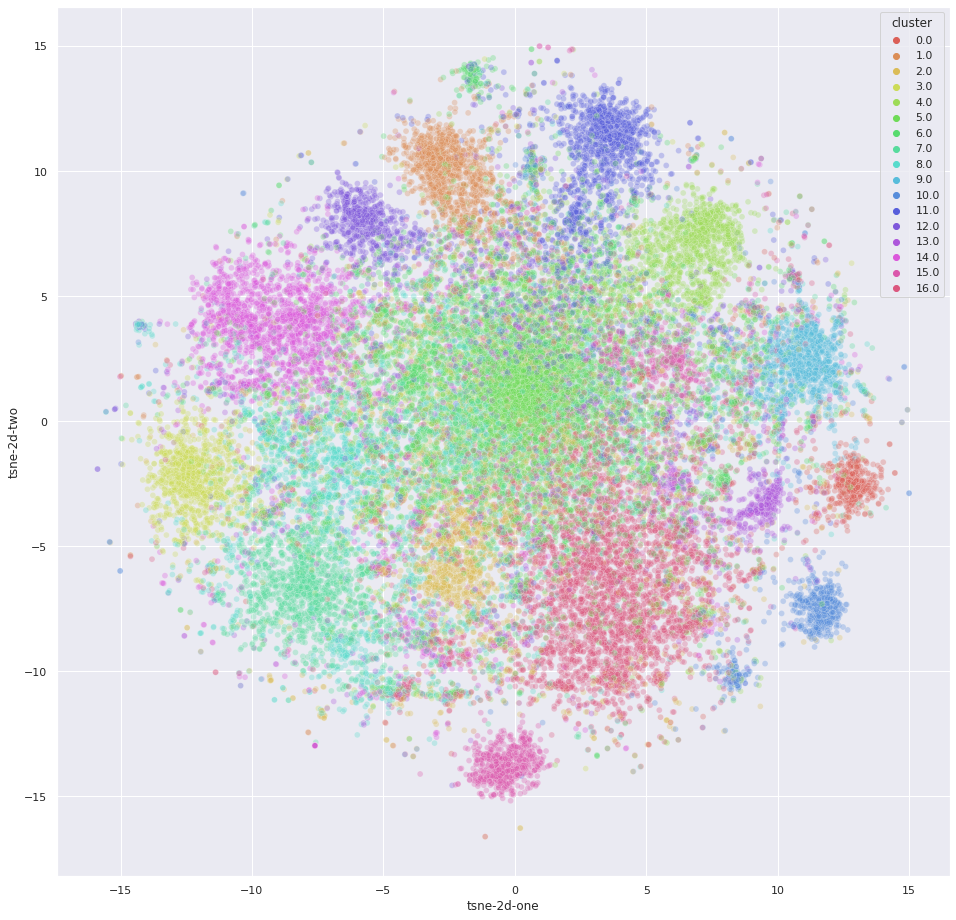

In [ ]:
plt.figure(figsize=(16, 16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();

In [ ]:
latent_clusters, len(latent_clusters), len(feature_df)

(array([ 5., 15.,  4., ..., 16.,  4., 12.]), 38010, 38010)

In [ ]:
feature_df['latent_cluster'] = latent_clusters

department_names = np.setdiff1d(prior_orders_details['department'].unique(), ['other', 'missing'])
interpetation_department = feature_df.groupby('latent_cluster')[department_names].mean()

interpetation_department.T.div(interpetation_department.sum(axis=1)).round(3)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
alcohol,0.001,0.000,0.000,0.000,0.008,0.009,0.004,0.000,0.000,0.006,0.022,0.009,0.001,0.002,0.000,0.041,0.001
babies,0.012,0.022,0.018,0.019,0.008,0.011,0.009,0.012,0.016,0.000,0.009,0.010,0.014,0.008,0.014,0.003,0.014
bakery,0.029,0.047,0.039,0.028,0.049,0.029,0.035,0.021,0.035,0.035,0.052,0.050,0.034,0.031,0.023,0.047,0.050
beverages,0.160,0.107,0.072,0.061,0.096,0.102,0.104,0.056,0.064,0.097,0.100,0.091,0.077,0.122,0.056,0.109,0.065
breakfast,0.019,0.037,0.017,0.015,0.030,0.019,0.024,0.016,0.018,0.024,0.022,0.029,0.032,0.025,0.019,0.027,0.019
bulk,0.001,0.000,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.003,0.000,0.000,0.000,0.001,0.002,0.000,0.002
canned goods,0.028,0.033,0.030,0.036,0.035,0.029,0.035,0.036,0.033,0.022,0.030,0.046,0.038,0.020,0.033,0.038,0.031
dairy eggs,0.142,0.154,0.163,0.166,0.169,0.157,0.148,0.169,0.181,0.107,0.175,0.153,0.171,0.235,0.167,0.142,0.196
deli,0.026,0.026,0.032,0.042,0.031,0.029,0.036,0.032,0.034,0.020,0.033,0.025,0.024,0.027,0.032,0.021,0.043
dry goods pasta,0.021,0.033,0.026,0.026,0.030,0.022,0.025,0.030,0.027,0.008,0.030,0.037,0.036,0.015,0.030,0.028,0.026


In [ ]:
interpetation_aisle = feature_df.groupby('latent_cluster')[feature_df.columns.values[16:-1]].mean()
interpetation_aisle.T.div(interpetation_aisle.sum(axis=1)).round(3).head(20)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
pantry,0.035,0.046,0.035,0.036,0.048,0.040,0.044,0.035,0.037,0.035,0.045,0.056,0.049,0.033,0.036,0.049,0.035
personal care,0.012,0.034,0.008,0.005,0.017,0.012,0.014,0.004,0.007,0.005,0.012,0.012,0.010,0.008,0.005,0.008,0.006
pets,0.001,0.006,0.001,0.001,0.004,0.002,0.003,0.001,0.001,0.000,0.006,0.004,0.003,0.002,0.000,0.004,0.001
produce,0.201,0.096,0.233,0.241,0.142,0.199,0.166,0.252,0.215,0.259,0.142,0.150,0.170,0.170,0.253,0.146,0.223
snacks,0.059,0.079,0.058,0.049,0.068,0.064,0.075,0.044,0.059,0.072,0.066,0.064,0.065,0.087,0.045,0.066,0.052
air fresheners candles,0.000,0.002,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.001,0.000
asian foods,0.003,0.003,0.004,0.003,0.005,0.004,0.005,0.003,0.003,0.000,0.004,0.004,0.004,0.002,0.003,0.003,0.004
baby accessories,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
baby bath body care,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
baby food formula,0.007,0.013,0.011,0.012,0.005,0.007,0.005,0.008,0.011,0.000,0.005,0.006,0.008,0.005,0.009,0.001,0.009


In [ ]:
prior_orders_details_clustered = prior_orders_details.copy()
prior_orders_details_clustered = prior_orders_details_clustered.merge(feature_df['latent_cluster'], on='user_id', how='left')
prior_orders_details_clustered.to_csv('./output/prior_orders_details_clustered_{0}p_{1}d.csv'.format(data_usage*100, len(tsne_doc_features.columns)-1))

for cluster_id in [7.0, 3.0]:
    prior_orders_details_clustered[prior_orders_details_clustered['latent_cluster']==cluster_id][['user_id', 'product_name']].groupby("user_id").apply(lambda order: ' > '.join(order['product_name'])).reset_index().head(10)

,user_id,0
0,487,"Tzatziki > Organic Biologique Limes > Organic Cranberry Pomegranate Juice > Organic Plain Whole Milk Yogurt > Organic Mango Chunks > Red Onion > Organic Vidalia Onion > Organic Garlic > Organic Red Potato Bag > Mini Original Babybel Cheese > Mozzarella Cheese > Organic Tomato Sauce > Coconut Water > 100% Raw Coconut Water > Uncured Genoa Salami > Uncured Hard Salami > Organic Strawberries > Clementines, Bag > Tzatziki > Organic Cranberry Pomegranate Juice > Organic Strawberries > Large Pinea..."
1,567,Chicken & Maple Breakfast Sausage > Organic Black Beans > Organic Pinto Beans > Organic Great Northern Beans > Organic Diced Tomatoes > Chopped Tomatoes > Organic Yellow Onion > Vanilla Nonfat Yogurt > Cage Free Real Egg Product > Boneless Skinless Chicken Breasts > Organic Gala Apples > Banana > Organic Avocado > Cran Raspberry Sparkling Water > Vanilla Almond Fit Granola > Organic Edamame > 100% Recycled Aluminum Foil > Organic Gala Apples > Teriyaki Chicken Bowl > Natural Chicken & Sage B...
2,650,"Organic Hothouse Cucumbers > Limes > Chicken & Vegetable Snack Sticks for Dogs > Organic Baby Spinach > Uncured Black Forest Ham > Limes > Organic Red Radish, Bunch > Organic Green Cabbage > Organic Baby Spinach > Organic Hothouse Cucumbers > Organic Red Radish, Bunch > Fresh Cauliflower > Chicken & Vegetable Snack Sticks for Dogs > Organic Baby Spinach > Dairy Free Original Coconutmilk Coffee Creamer > Organic Large Brown Eggs > Organic Jalapeno Pepper > Organic Hothouse Cucumbers > Organic..."
3,651,Large Lemon > Asparagus > Tilapia Filet > Organic Avocado > Organic Baby Kale > Green Grapes > Lime Italian Sparkling Mineral Water > Relaxing Lavender Bubble Bath > Bag of Organic Bananas > Asparagus > Boneless Skinless Chicken Breasts > Roasted & Salted Almonds > Lime Italian Sparkling Mineral Water > Organic Baby Broccoli > Beef Loin New York Strip Steak > Natural Spring Water > Tilapia Filet > Asparagus > Air Chilled Breaded Chicken Breast Nuggets > Bag of Organic Bananas > Organic Yello...
4,657,"Unsweetened Almondmilk > Vodka Pasta Sauce > Strawberries > Large Pineapple Chunks > Bacon Style Veggie Protein Strips > Organic Tomato Cluster > Gelato Squares, Key Lime Graham > Vegetable Egg Rolls > Russet Potato > Organic Spring Mix > Organic Grape Tomatoes > Peanut Butter Creamy With Salt > Sweet & Salty Kettlecorn > Organic Spring Mix > Chopped Spinach > Huevos Rancheros Breakfast Wrap > Chicken Chorizo Cafe Wrap > Cafe Latte Pure Lightly Sweetened Iced Coffee With Almond Milk > Organi..."
5,699,"Organic Blackberries > Organic Whole String Cheese > Organic Muenster Cheese Slices > Large Pineapple Chunks > Clementines, Bag > Organic Large Extra Fancy Fuji Apple > Non GMO Organic Brown Eggs > Grape White/Green Seedless > Organic Frozen Mango Chunks > Breaded Chicken Breast Nuggets, Gluten Free > Black Plum > Organic Baby Spinach > Oven Roasted Turkey Breast > Organic Summer Strawberry Bunny Fruit Snacks > Organic Whole String Cheese > Large Pineapple Chunks > Gluten Free Whole Grain Br..."
6,721,The Original Worcestershire Sauce > Beef Broth > Russet Potato > Carrots > Strawberries > 2% Reduced Fat Organic Milk > Organic Cream Of Chicken Condensed Soup > Boneless Skinless Chicken Breasts > Cucumber Kirby > Small Macintosh Apple > Sweet Potato Fries with Sea Salt > 2% Reduced Fat Organic Milk > Boneless Skinless Chicken Breasts > Original Cooking Chicken Stock > Diced Tomatoes > Mild Diced Green Chiles > Organic Tomato Sauce > Bunched Cilantro > Sour Cream > Penne Rigate #41 Pasta > ...
7,722,100% Recycled White Paper Towels > Blueberries > Raspberries > Unsweetened Original Almond Breeze Almond Milk > Organic Wheat-Free & Gluten-Free Original Crackers > Whole Milk Ricotta Cheese > Organic Sticks Low Moisture Part Skim Mozzarella String Cheese > Organic Raw Sharp Cheddar Cheese > Unsweetened Original Almond Breeze Almond Milk > Raspberries > Cucumber Kirby > Blueberries > Organic Celery Hearts > Organic Extra Firm Tof

,user_id,0
0,197,"Organic Blackberries > Organic Lightly Salted Sea Salt Thin & Crispy Restaurant Style Tortilla Chips > Raw Goat Milk Sharp Cheddar Cheese > Organic Roasted Turkey Breast > Uncured Genoa Salami > Carrots > Organic Baby Spinach > Organic Avocado > Villagio Marzano Heavenly Tomatoes > Organic Bunch Beets > Parsnip > Sweet Potatoes > Organic Yellow Onion > Tomato Sauce > Organic Tomato Paste > Creamy Almond Butter > Organic Chili Powder Blend > Nuts & Spices, Dark Chocolate Mocha Almond > Air Ch..."
1,208,90% Lean Ground Beef > Just Green Unsweetened Tea > Organic Strawberries > Peach Mango Iced Green Tea > Zero Calorie Iced Green Tea Raspberry > Cucumber Kirby > Organic Yellow Onion > Ground Turkey Breast > Homemade Hot Arrabbiata Fra Diavolo Sauce > Lettuce Medley > Jalapeno Cilantro Salsa > Organic Broccoli > Red Vine Tomato > Peach Mango Iced Green Tea > Zero Calorie Iced Green Tea Raspberry > Kelp Noodles > Homemade Hot Arrabbiata Fra Diavolo Sauce > Just Green Unsweetened Tea > Ground T...
2,223,Organic Blueberries > Organic Strawberries > Organic Unsweetened Almond Milk > Plantain Chips > Organic Quick Oats > Nonfat Icelandic Style Strawberry Yogurt > Uncured Bacon + Cranberry Bison Bar > Roasted Red Pepper Hummus With Chips > 100% Pomegranate Blueberry Juice > Blueberry Muffin Bar > Banana Bread Fruit & Nut Bar > Organic Blueberries > Organic Strawberries > Organic Roasted Turkey Breast > Almond Paleo Bread Non GMO Gluten Free > Organic Egg Whites > Apple Honeycrisp Organic > Vani...
3,351,Fat Free Milk > Organic Whole Milk > Banana > Frozen Organic Wild Blueberries > Yellow Onions > 100% Whole Wheat Bread > Organic Hass Avocado > Original Puffins Cereal > Organic Sriracha Hummus > Organic Old Fashioned Rolled Oats > Roma Tomato > Fat Free Milk > Organic Whole Milk > Organic Gala Apples > Seedless Red Grapes > Chopped Organic Garlic > Organic Zucchini > Organic Original Hommus > Banana > Organic D'Anjou Pears > Organic Sweet Mini Peppers > Mini Whole Wheat Pita Bread > Sliced ...
4,616,Cage Free Grade A Large Brown Eggs > S'mores Luna Bar > Boneless Skinless Chicken Breasts > Organic Zucchini > Non Fat Raspberry Yogurt > Strawberry Rhubarb Yogurt > Thin And Crispy Corn Tortilla Chips > Organic Spring Mix > Shells & Real Aged Cheddar Macaroni & Cheese > Organic Strawberries > Limes > Organic Cheese Frozen Pizza > Organic Vanilla Extract > Bunched Cilantro > Pineapple > Organic Peeled Whole Baby Carrots > Organic Blackberries > Jalapeno Cilantro Salsa > Thin And Crispy Corn ...
5,735,Organic Whole Milk with DHA Omega-3 > Bag of Organic Bananas > Soft Pretzel Mini Buns > Organic Raspberries > Mild Thin Sliced Cheddar Cheese > Organic Skim Milk with DHA Omega-3 > Organic Peace Pasta & Parmesan Macaroni & Cheese > Rosemary Ham > Asparagus Spears > Organic Baby Spinach > Sweet Potato Tortilla Chips > Watermelon Chunks > Organic Honey Graham Crackers > Grass Fed Beef Stew Meat > Organic Yellow Onion > Organic Green Seedless Grapes > Uncured Genoa Salami > Mini Peanut Butter S...
6,859,"Vanilla Bean Light Ice Cream > Banana > Organic Avocado > Orange Sparkling Water > Cold-Brew Black Coffee > Organic Roasted Turkey Breast > Total 0% Greek Yogurt > Organic Egg Whites > Organic Red Bell Pepper > Organic Turkey Bacon > Direct Trade Organic El Gallo Breakfast Blend Whole Bean Coffee > Organic Chocolate Chip Chewy Granola Bars > Organic Bunny Fruit Snacks Berry Patch > Cut Tulips (Choose Color) > Lemon Verbena Candle > Purifying, 2-in-1 Charcoal Mask > Organic Yellow Onion > Org..."
7,911,Original Semisoft Cheese > Russet Potatoes > Ataulfo Mango > Free & Clear Natural Laundry Detergent For Sensitive Skin > Caraway Crackers > Baked White Cheddar Cheese Puffs > Organic Whole Milk > Organic Red Bell Pepper > Roasted Turkey Breast > Organic White Cheddar Popcorn > Organic Whole Milk Strawberry Kefir > Organic Strawberries > Fancy Eggplant > Mandarin Oranges > Ataulfo Mango > Free & Clear Natural Laundry Detergent For Sen